Please install arviz for the visualization of bayesian model

In [19]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pymc3 as pm
import sys


# import a new plot module to plot all graphs of PyMC3. 
import arviz 
import warnings
warnings.simplefilter('ignore', UserWarning)

In [20]:
google=pd.read_csv("google.csv",index_col=0)
google.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-31,529.795471,531.141724,524.360352,524.958740,524.958740,1368200
2015-01-02,527.561584,529.815369,522.665039,523.373108,523.373108,1447500
2015-01-05,521.827332,522.894409,511.655243,512.463013,512.463013,2059800
2015-01-06,513.589966,514.761719,499.678131,500.585632,500.585632,2899900
2015-01-07,505.611847,505.855164,498.281952,499.727997,499.727997,2065000


In [21]:
google.shape

(1447, 6)

## Bayesian Model of Risk and Reward

Text(0, 0.5, 't-distribution')

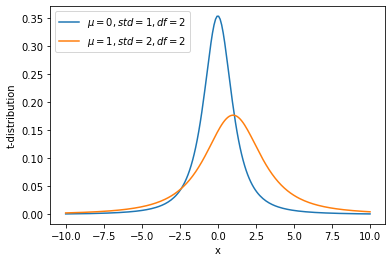

In [22]:
from scipy.stats import t
x = np.linspace(-10,10,200)
plt.plot(x, t.pdf(x,df=2),label='$\mu=0,std=1,df=$'+str(2))

plt.plot(x, t.pdf(x,2,loc=1, scale=2),label='$\mu=1,std=2,df=$'+str(2))
plt.legend(loc='upper left')
plt.xlabel("x")
plt.ylabel("t-distribution")



In [23]:
from scipy.stats import expon

In [24]:
ld=2# lamabda=2
x = np.linspace(0,1,200) # the range is x>=0, we only visualize x in [0,1]

Text(0, 0.5, '$p(x|\\lambda)$')

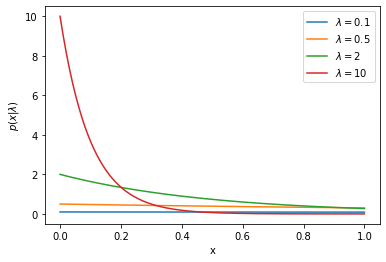

In [25]:
for ld in [0.1,0.5,2,10]:
    plt.plot(x,  expon.pdf(x,scale=1/ld),label='$\lambda=$'+str(ld))
    plt.legend()
plt.xlabel("x")
plt.ylabel("$p(x|\lambda)$")


In [26]:
google["return"]=google["Close"].pct_change()
google=google.dropna(axis=0)# drop row if the row has NaN

In [27]:
rmean =google["return"].mean()
rstd=google["return"].std()
rmean,rstd# realized mean and std from historical data

(0.0008546799145806177, 0.016939579481752374)

In [11]:
rmean =google["return"].mean()
rstd=google["return"].std()
uniformL = rstd/ 1000 # low bound and upperbound for the uniform prior of standard devation.
uniformU = rstd * 1000

with pm.Model() as sr_model:
    #three prior
    mean = pm.Normal('mean', mu=rmean, sd=rstd)
    std = pm.Uniform('std', lower=uniformL, upper=uniformU)
    df = pm.Exponential('df', 1 / 29,testval=5) + 2.# make the df is around 2
    # testval is the initial value to start sample. 
    # likelihood
    returns = pm.StudentT('returns', nu=df, mu=mean, sd=std, observed=google["return"]) #nu is degree of freedowm

    sharpe = returns.distribution.mean / returns.distribution.variance ** .5 * np.sqrt(252)
    pm.Deterministic('sharpe', sharpe) # Not a distribution

In [12]:
tune = 4000
draws = 1000
with sr_model:
    trace = pm.sample(tune=tune, 
                      draws=draws, 
                      chains=4,random_seed=8888)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [df, std, mean]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 99 seconds.


In [13]:
trace_df = pm.trace_to_dataframe(trace).assign(chain=lambda x: x.index // draws)
trace_df.shape

(4000, 5)

In [14]:
trace_df.head()


,mean,std,df,sharpe,chain
0,0.001156,0.009553,0.462719,0.832620,0
1,0.001271,0.009976,0.893997,1.124110,0
2,0.001160,0.010196,0.879283,0.997885,0
3,0.001025,0.010077,0.582156,0.767040,0
4,0.001466,0.009939,0.710966,1.198805,0


In [15]:
from pymc3.plots import  plot_posterior,traceplot

/Users/kenneth/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13cc08898>,
      dtype=object)

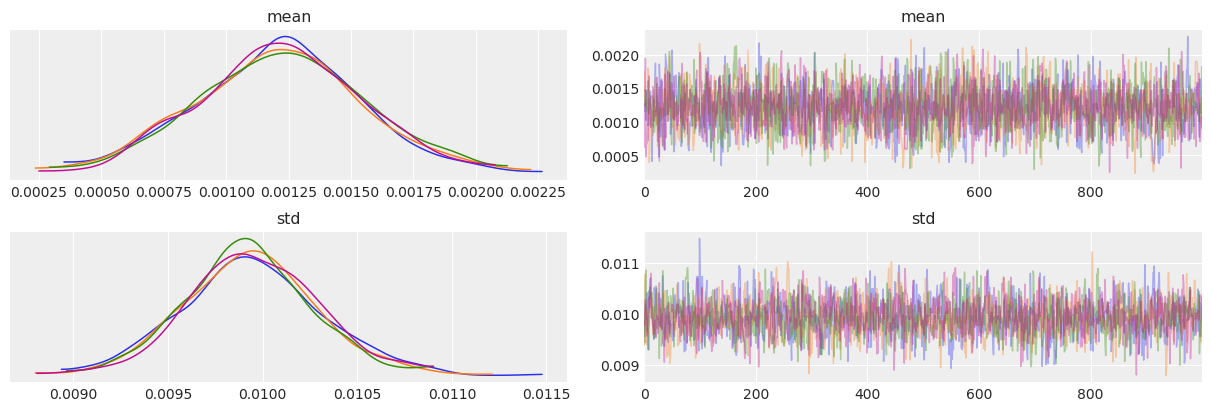

In [16]:
import arviz as az

az.style.use("arviz-darkgrid")
az.plot_trace(trace, var_names=("mean", "std"))



/Users/kenneth/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13c84ec18>,
      dtype=object)

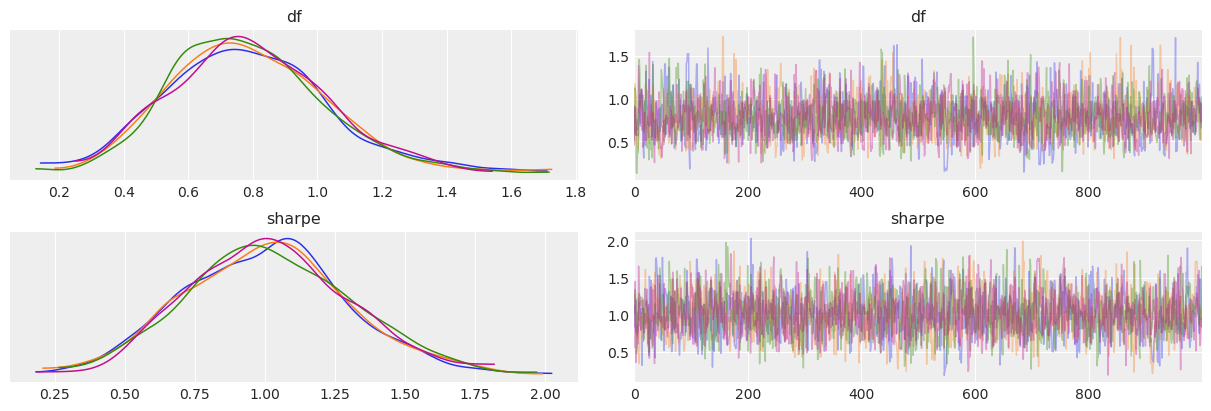

In [17]:
az.style.use("arviz-darkgrid")
az.plot_trace(trace, var_names=("df", "sharpe"))


/Users/kenneth/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


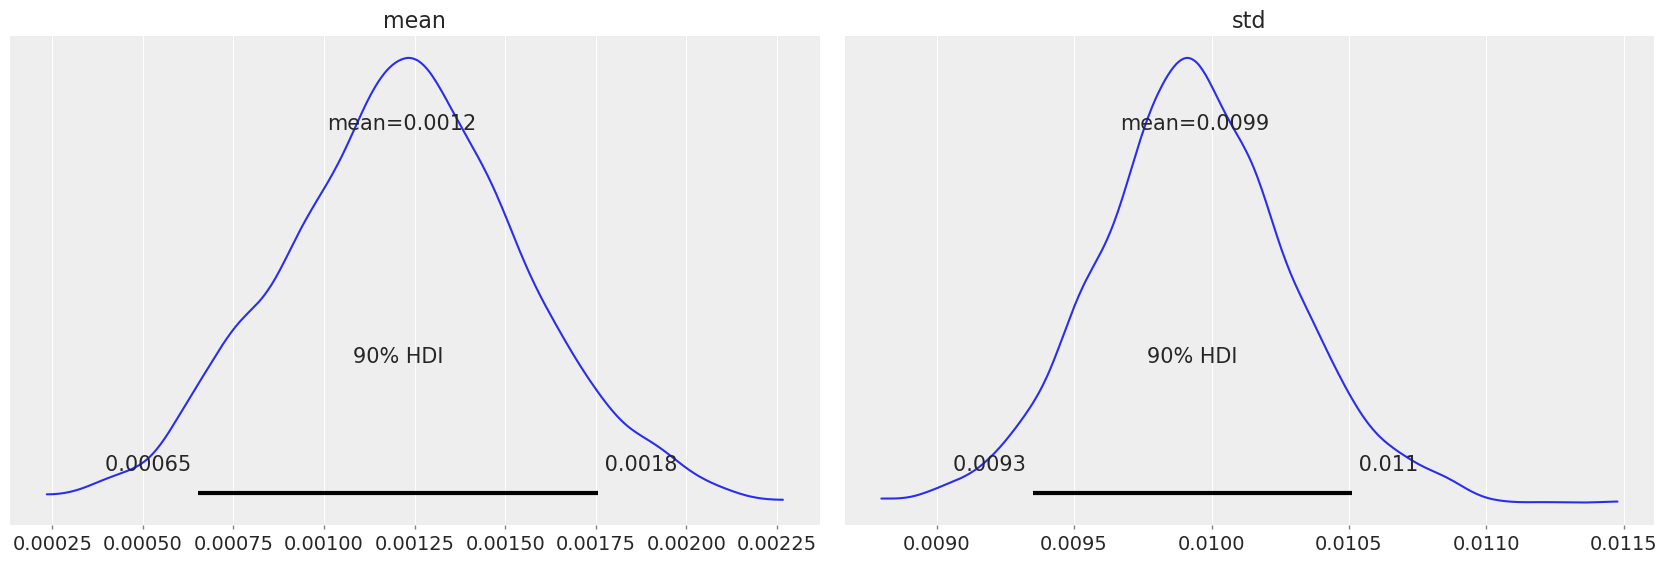

In [18]:
az.style.use("arviz-darkgrid")
ax=az.plot_posterior(trace,var_names=("mean","std"), credible_interval=0.9)



array([<matplotlib.axes._subplots.AxesSubplot object at 0x1380f1278>,
      dtype=object)

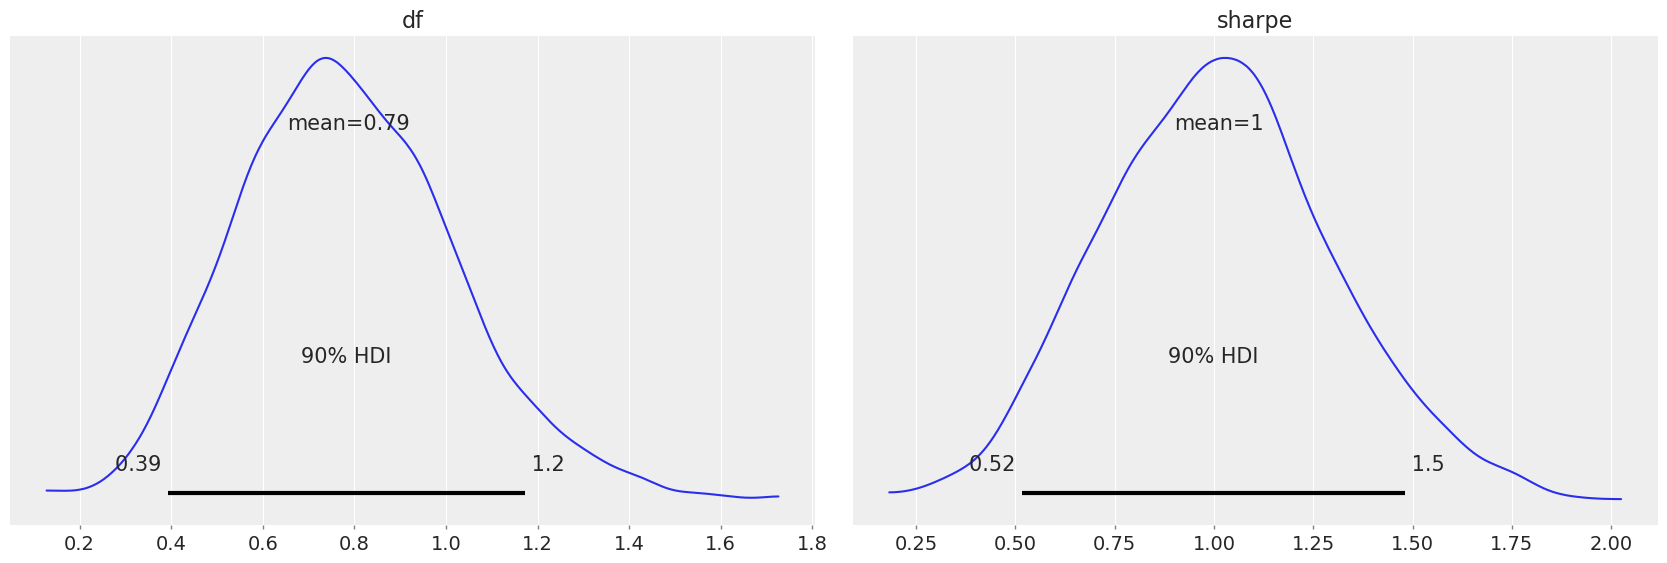

In [19]:
az.style.use("arviz-darkgrid")
az.plot_posterior(trace,var_names=("df","sharpe"),credible_interval=0.9)


0.800942139199426


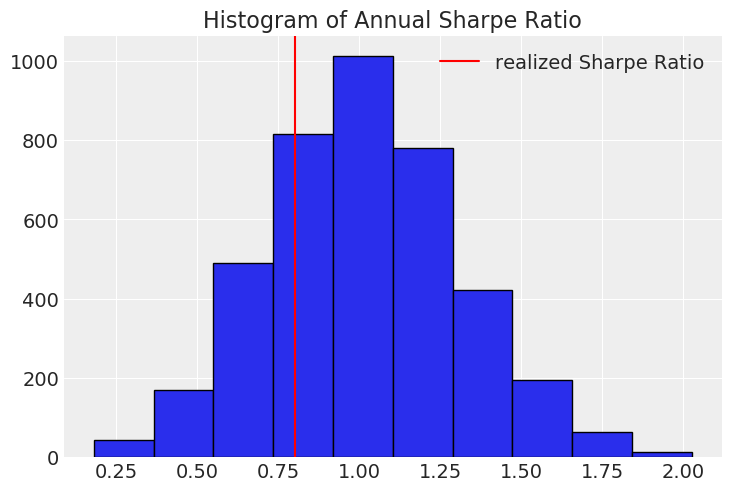

In [20]:
plt.hist(trace["sharpe"],ec='black'); # four chains 
plt.title("Histogram of Annual Sharpe Ratio")
plt.axvline((252**0.5)*rmean/rstd, color="red", label="realized Sharpe Ratio")
print((252**0.5)*rmean/rstd)
plt.legend()


# Bayesian Regression with Artifical Data

In [21]:
size = 200
beta0 = 1
beta1 = 2
data=pd.DataFrame()
data["x"]=np.linspace(0, 1, size)
data["mu"]=beta0 + beta1 * data["x"]
data["y"]=data["mu"]+np.random.normal(scale=.5, size=size)

In [22]:
data.head()


,x,mu,y
0,0.000000,1.000000,0.586866
1,0.005025,1.010050,1.074366
2,0.010050,1.020101,1.318150
3,0.015075,1.030151,1.226623
4,0.020101,1.040201,1.498033


## Method 1: 

In [23]:
with pm.Model() as linear_regression1: # model specification
    # Define priors, unique name for each variable
    std = pm.HalfCauchy('sigma', beta=10, testval=1) 
    beta0 = pm.Normal('intercept', 0, sd=20)
    beta1 = pm.Normal('slope', 0, sd=20)
    # Define likelihood
    likelihood = pm.Normal('y', 
                           mu=beta0 + beta1 *data["x"],
                           sd=std, 
                           observed=data["y"])

In [24]:
tune=6000
draws=2500
with linear_regression1:
    trace1 = pm.sample(tune=tune,
                    draws=draws,
                      cores=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [slope, intercept, sigma]


Sampling 2 chains for 6_000 tune and 2_500 draw iterations (12_000 + 5_000 draws total) took 62 seconds.
The acceptance probability does not match the target. It is 0.8871512608249326, but should be close to 0.8. Try to increase the number of tuning steps.


In [25]:
trace_df1 = pm.trace_to_dataframe(trace1).assign(chain=lambda x: x.index // draws)
trace_df1.shape 

(5000, 4)

In [26]:
trace_df1.head()


,intercept,slope,sigma,chain
0,1.099552,1.825028,0.507582,0
1,1.002662,1.991671,0.564299,0
2,1.018408,2.020673,0.497769,0
3,1.018408,2.020673,0.497769,0
4,1.037982,1.994670,0.554240,0


/Users/kenneth/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1375d7860>,
      dtype=object)

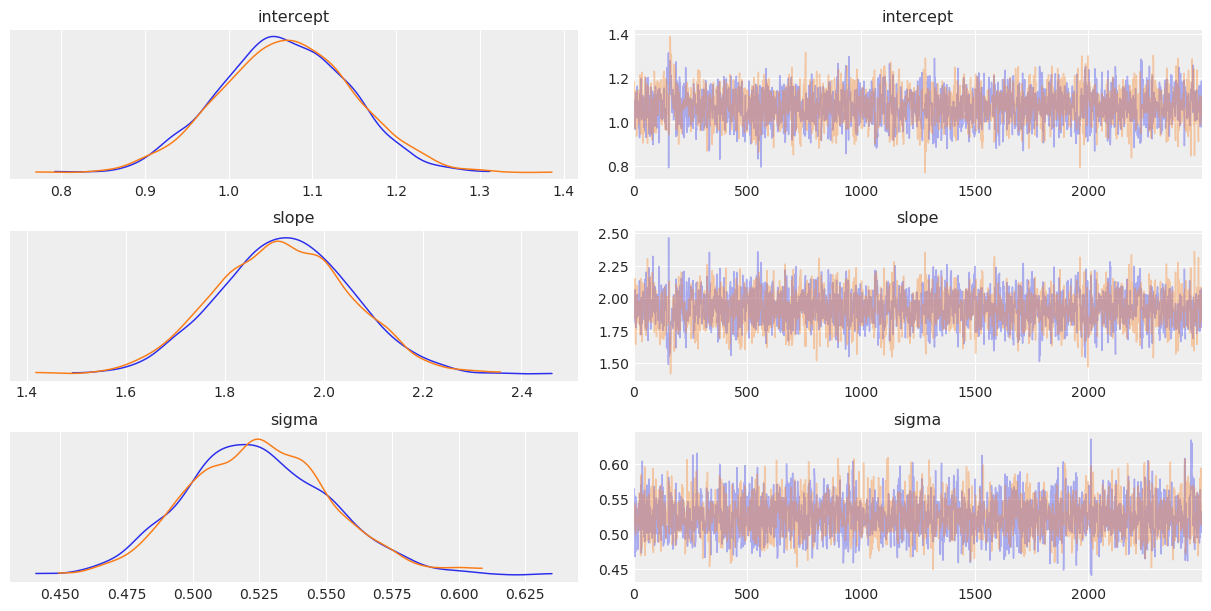

In [27]:

az.plot_trace(trace1, var_names=("intercept", "slope","sigma"))


/Users/kenneth/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11bbb52b0>,
      dtype=object)

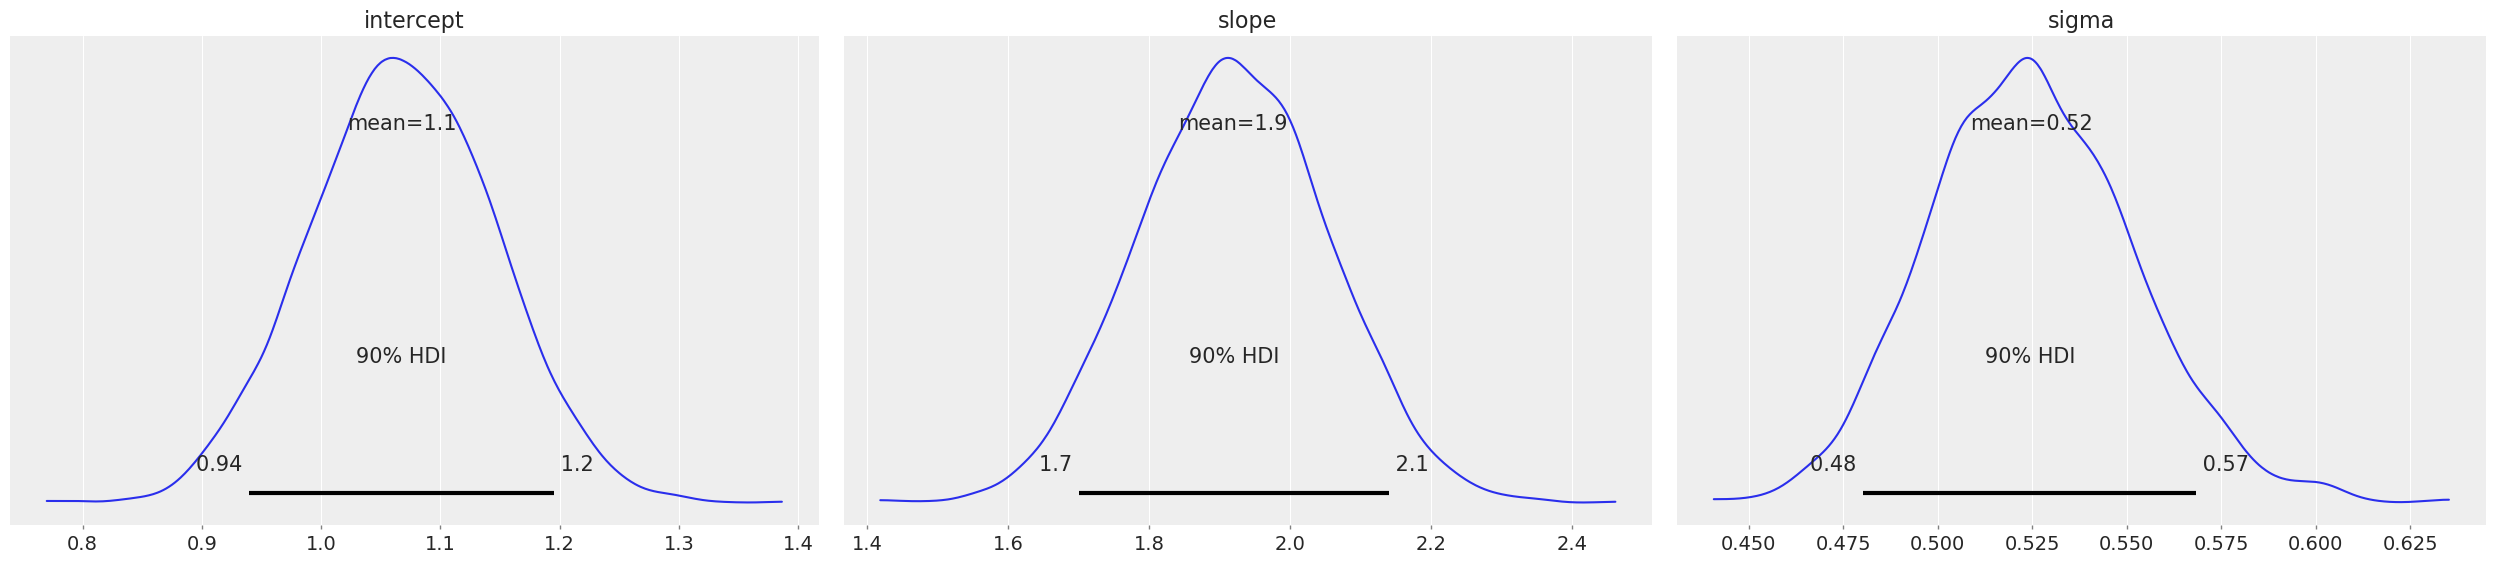

In [28]:
pm.plot_posterior(trace1,credible_interval=0.9)

In [29]:
trace_df1 = pm.trace_to_dataframe(trace1).assign(chain=lambda x: x.index // draws)
trace_df1.shape 

(5000, 4)

## Method II:  Use glm() 

In [30]:
data.head()

,x,mu,y
0,0.000000,1.000000,0.586866
1,0.005025,1.010050,1.074366
2,0.010050,1.020101,1.318150
3,0.015075,1.030151,1.226623
4,0.020101,1.040201,1.498033


In [31]:
with pm.Model() as linear_regression2:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    pm.glm.GLM.from_formula('y ~ x', data)
  

In [32]:
tune=600
draws=2500
with linear_regression2:
    trace2 = pm.sample(tune=tune,
                    draws=draws,
                      cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, x, Intercept]


Sampling 2 chains for 600 tune and 2_500 draw iterations (1_200 + 5_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.897644886027529, but should be close to 0.8. Try to increase the number of tuning steps.


In [33]:
trace_df2 = pm.trace_to_dataframe(trace2).assign(chain=lambda x: x.index // draws)
trace_df2.shape 

(5000, 4)

In [34]:
trace_df2.head()


,Intercept,x,sd,chain
0,1.139616,1.803427,0.527736,0
1,1.043334,1.877560,0.524002,0
2,1.126340,1.904954,0.567812,0
3,1.055079,1.857360,0.524943,0
4,1.136881,1.859635,0.520200,0


/Users/kenneth/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x137802400>,
      dtype=object)

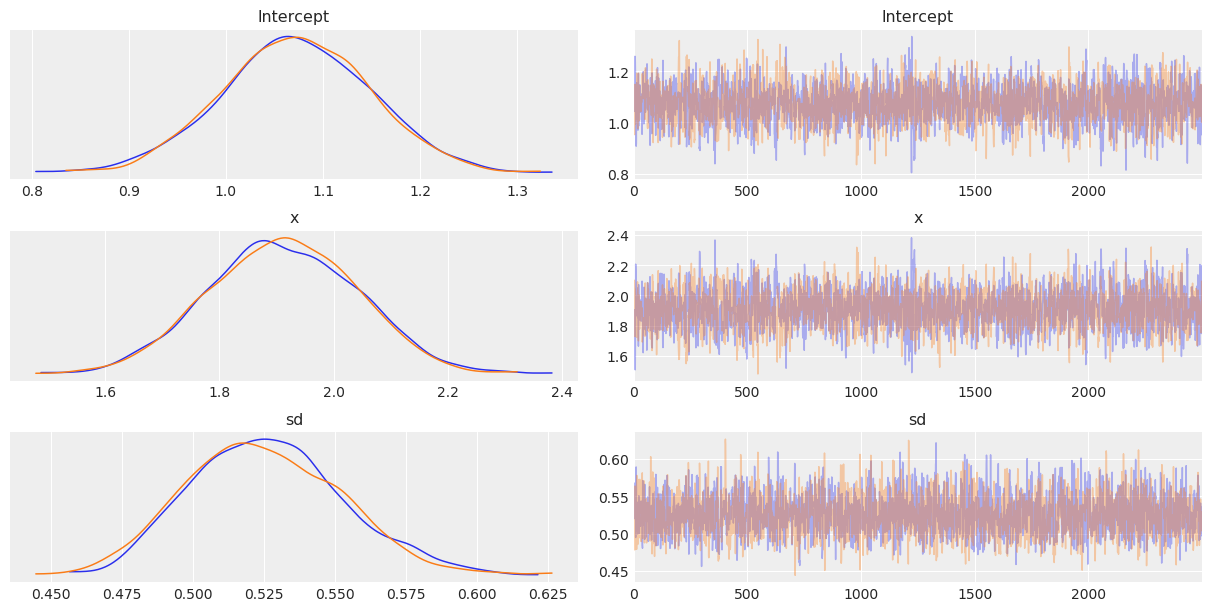

In [35]:

az.plot_trace(trace2, var_names=("Intercept", "x","sd"))


##  Prior and Posterior Predictive Checks 

In [36]:
size = 200
beta0 = 0.5
beta1 = 3
test=pd.DataFrame()
test["x"]=np.linspace(-10, 10, size)
test["mu"]=beta0 + beta1 * data["x"]
test["y"]=data["mu"]+np.random.normal(scale=6, size=size)


In [37]:
test["x"].values.mean().round(2),test["x"].values.std().round(2)

(0.0, 5.8)

In [38]:
test["y"].values.mean().round(2),test["y"].values.std().round(2)

(2.58, 5.61)

In [39]:
with pm.Model() as test_model:
    beta0 = pm.Normal("b0", 0.0, 10.0)
    beta1 = pm.Normal("b1", 0.0, 10.0)

    mu = beta0 + beta1 *test["x"]
    std = pm.Exponential("sd", 1.0)

    output = pm.Normal("obs", mu=mu, sigma=std, observed=test["y"])
    

In [40]:
with test_model:
    prior_checks = pm.sample_prior_predictive(samples=100, random_seed=89)

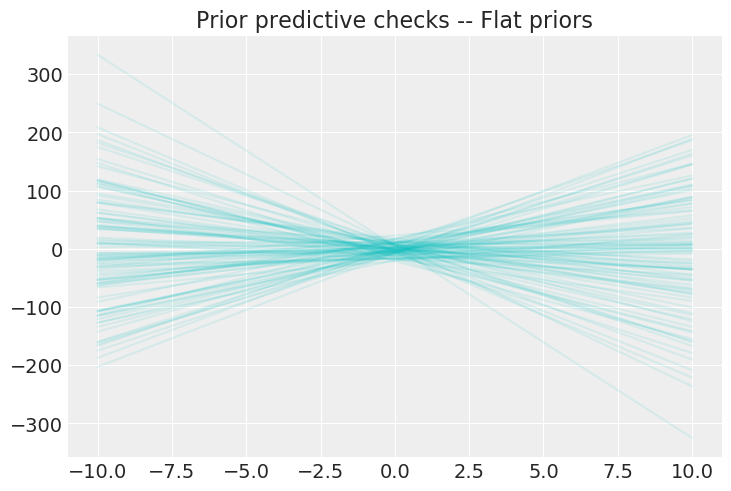

In [41]:
for intercept, slobe in zip(prior_checks["b0"], prior_checks["b1"]):
    y =intercept+ slobe *test["x"]
    plt.plot(test["x"], y, c="c", alpha=0.1)

plt.title("Prior predictive checks -- Flat priors");


In [42]:
with pm.Model() as test_model:
    beta0 = pm.Normal("b0", 0.0, 1.0)
    beta1 = pm.Normal("b1", 0.0, 1.2)

    mu = beta0 + beta1 *test["x"]
    std = pm.Exponential("sd", 1.0)

    output = pm.Normal("obs", mu=mu, sigma=std, observed=test["y"])
    

In [43]:
with test_model:
    prior_checks = pm.sample_prior_predictive(samples=100, random_seed=89)

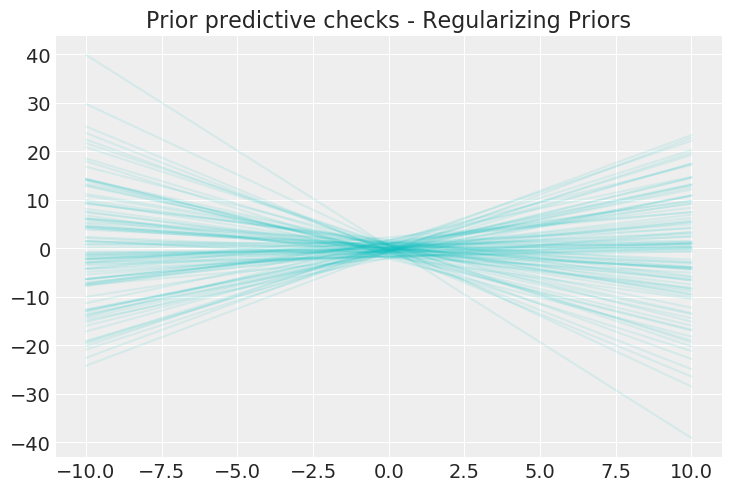

In [44]:
for intercept, slobe in zip(prior_checks["b0"], prior_checks["b1"]):
    y =intercept+ slobe *test["x"]
    plt.plot(test["x"], y, c="c", alpha=0.1)

plt.title("Prior predictive checks - Regularizing Priors");


In [37]:
import arviz as az

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, b1, b0]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 30 seconds.
/Users/kenneth/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13c98e4e0>,
      dtype=object)

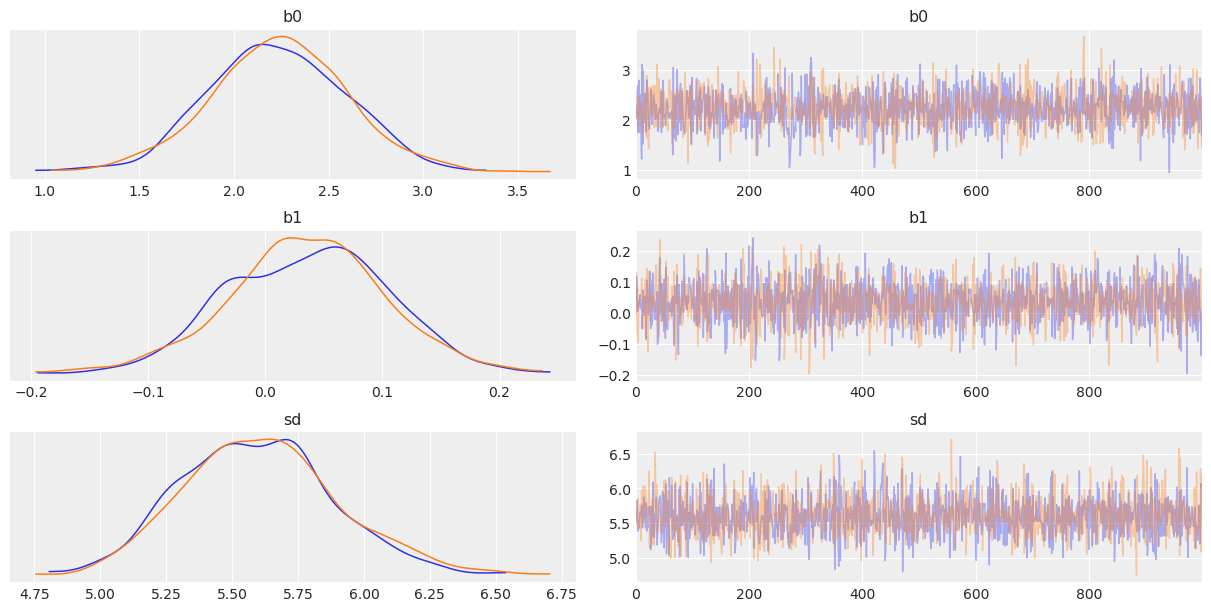

In [46]:
with test_model:
    test_trace = pm.sample(draws=1000, tune=2000, random_seed=80)
az.plot_trace(test_trace)


In [47]:
test_trace_df=pd.DataFrame(list(test_trace))
test_trace_df.shape

(1000, 4)

In [48]:
test_trace_df.head()


,b0,b1,sd,sd_log__
0,2.600583,-0.067051,5.445861,1.694856
1,2.081988,0.132699,5.695350,1.739650
2,2.294409,0.004839,5.526605,1.709574
3,1.891478,0.082070,5.501144,1.704956
4,2.179933,-0.095898,5.858490,1.767892


In [49]:
with test_model:
    ppc = pm.sample_posterior_predictive(
        test_trace, var_names=["b0", "b1", "obs"], random_seed=100
    )

In [50]:
ppc["b0"].shape,ppc["b1"].shape,ppc["obs"].shape

((2000,), (2000,), (2000, 200))

In [51]:
ppc["obs"].shape

(2000, 200)

/Users/kenneth/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


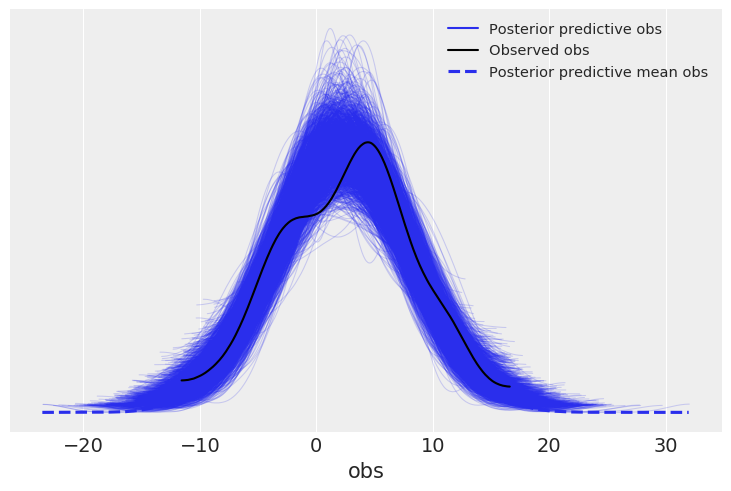

In [52]:
visual_data = az.from_pymc3(test_trace, posterior_predictive=ppc)
az.plot_ppc(visual_data)


# Robust Regression with Fat tails



In [53]:
size = 100
beta1 = 5
beta0 = 0.5
data2=pd.DataFrame()
data2["x"] = np.linspace(0, 1, size)
data2["mu"]= beta0 + beta1*data2["x"]
data2["y"]=data2["mu"]+np.random.normal(scale=.5, size=size)
print(data2.shape)
# next we add three outliers 
temp=pd.DataFrame()
temp["x"]= [.1, .15, .2]
temp["y"]=[8, 6, 9]
temp["mu"]=beta0 + beta1*temp["x"]
data2=pd.concat([data2,temp])
data2.shape

(100, 3)


/Users/kenneth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


(103, 3)

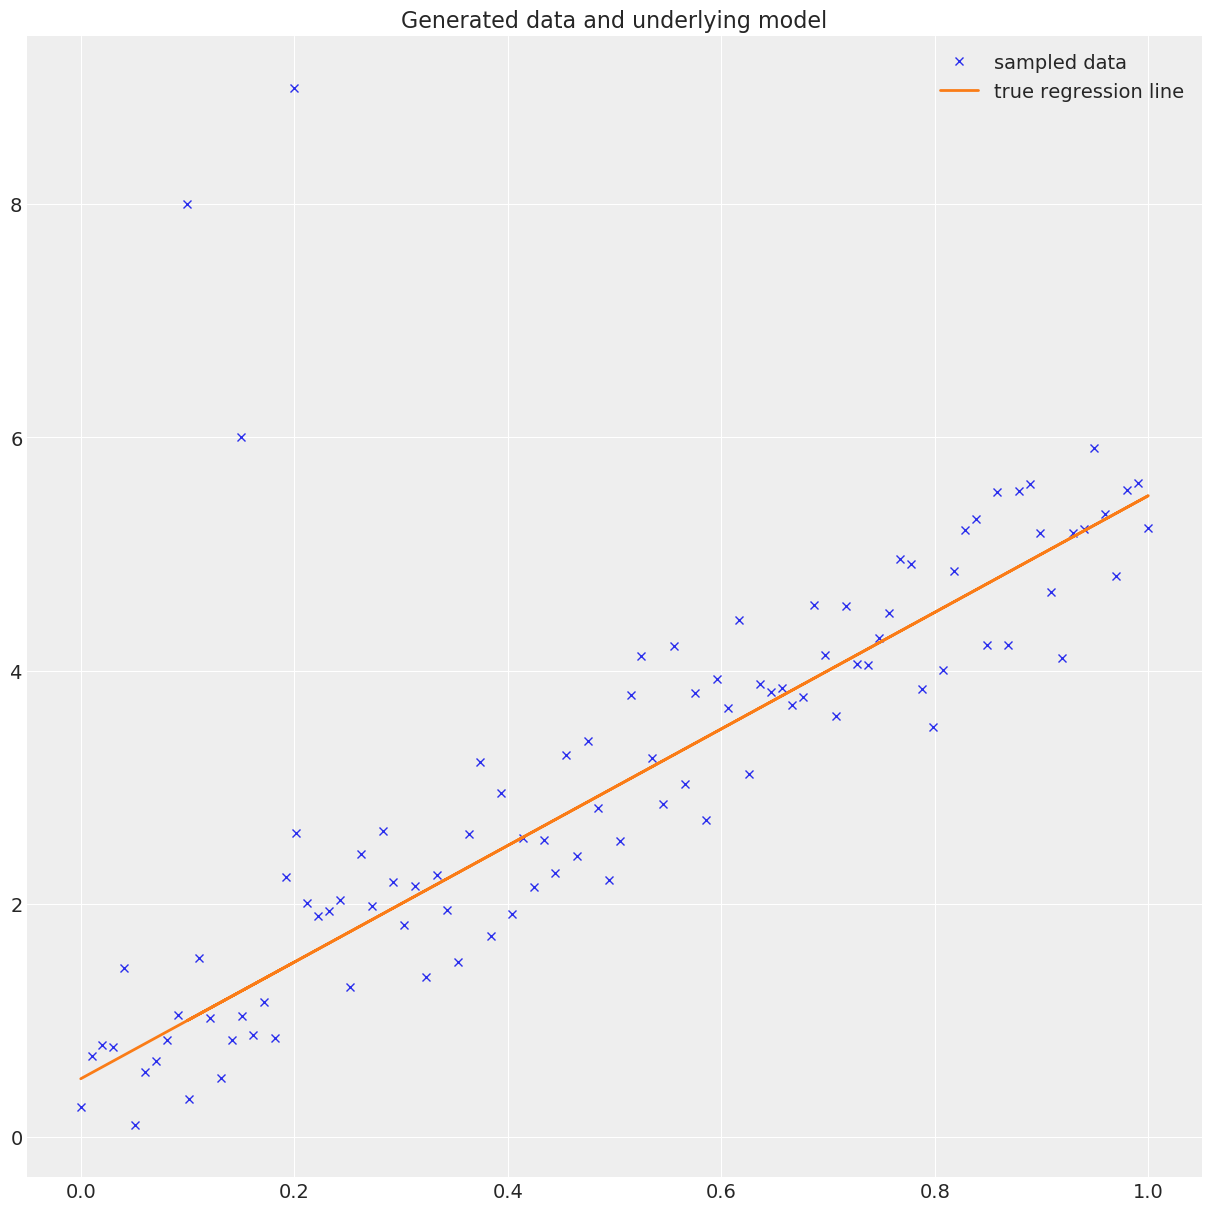

In [54]:
fig = plt.figure(figsize=(12, 12))
plt.title('Generated data and underlying model')
plt.plot(data2["x"], data2["y"], 'x', label='sampled data')
plt.plot(data2["x"], data2["mu"], label='true regression line', lw=2.)
plt.legend(loc=0)


describe the linear model and adds a Normal likelihood by default.

In [55]:
with pm.Model() as model:
    pm.GLM.from_formula('y ~ x', data2)
    trace3 = pm.sample(tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.


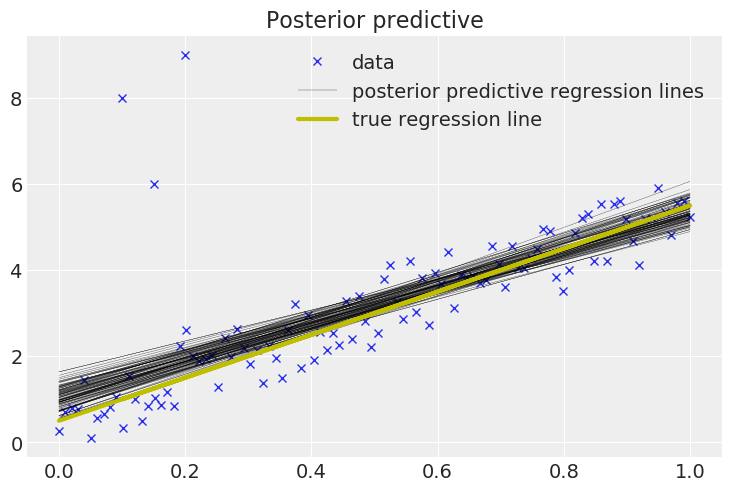

In [56]:
plt.plot(data2["x"], data2["y"], 'x', label='data')
pm.plot_posterior_predictive_glm(trace3, samples=100, 
                                 label='posterior predictive regression lines')
plt.plot(data2["x"], data2["mu"], 
         label='true regression line', lw=3., c='y')

plt.legend(loc=0)


In [57]:
with pm.Model() as  robust_model:
    f = pm.glm.families.StudentT()
    pm.GLM.from_formula('y ~ x', data2, family=f)
    robust_trace = pm.sample(tune=2000)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, x, Intercept]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 25 seconds.


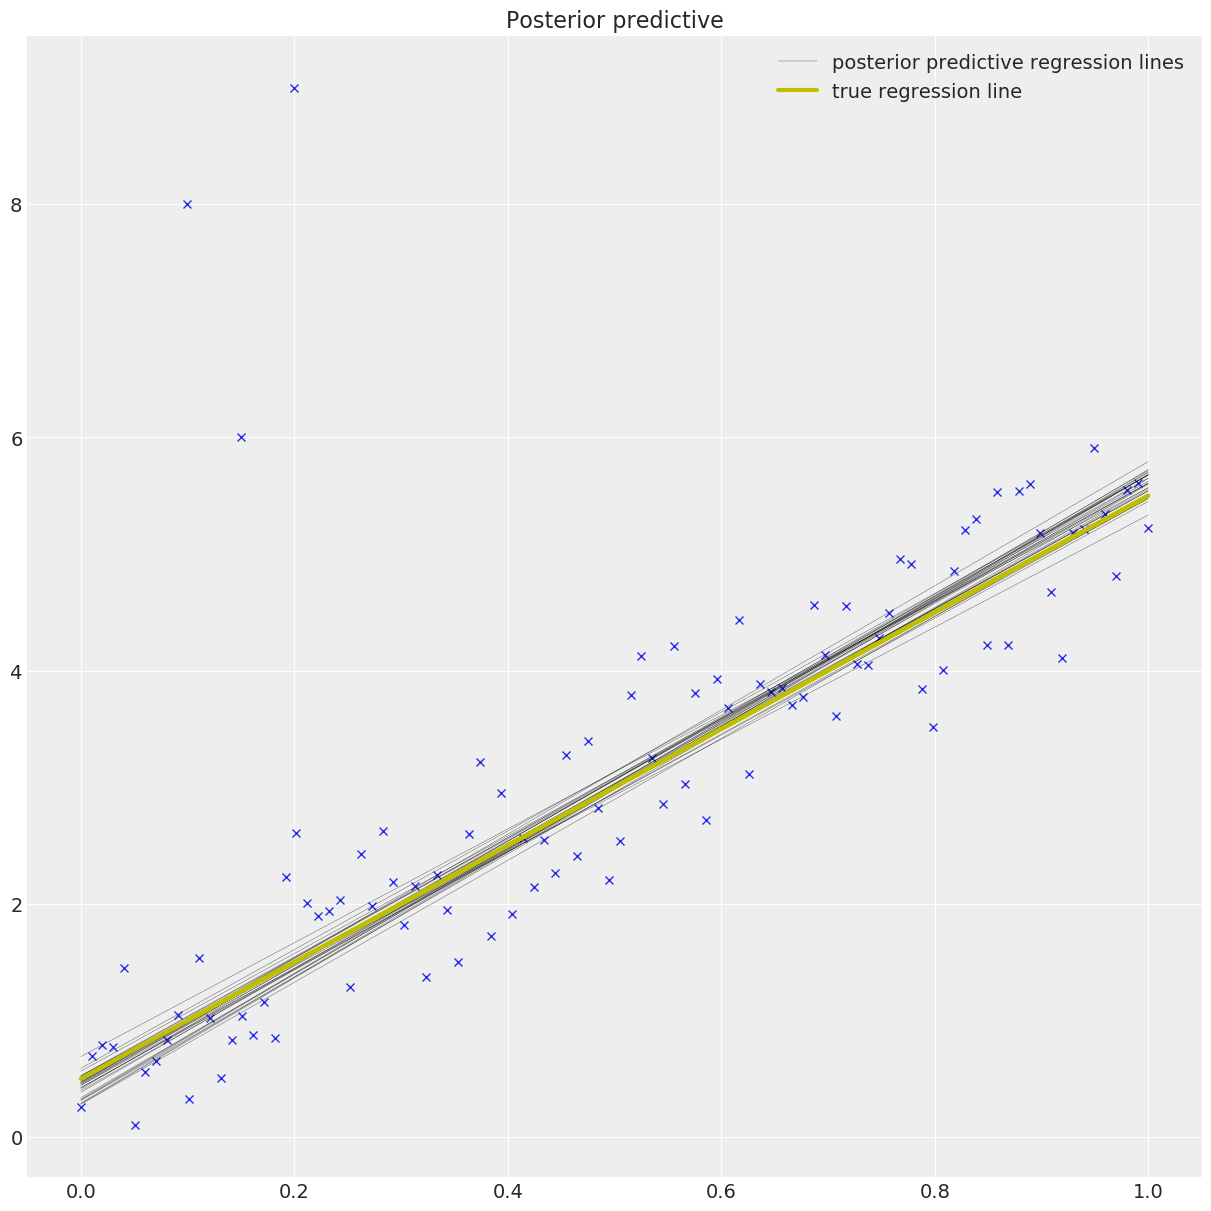

In [58]:
plt.figure(figsize=(12, 12))
plt.plot(data2["x"], data2["y"], 'x')
pm.plots.plot_posterior_predictive_glm(robust_trace,
                                       label='posterior predictive regression lines')
plt.plot(data2["x"], data2["mu"],
         label='true regression line', lw=3., c='y')
plt.legend();


In [59]:
with pm.Model() as my_model:
 
 
    std = pm.HalfCauchy('sigma', beta=10, testval=1)
    beta0 = pm.Normal('Intercept', 0, sd=20)
    beta1 = pm.Normal('slope', 0, sd=20)
    df = pm.Exponential('df', 1 / 29,testval=5) + 2.# make the df is around 2
    # testval is the initial value to start sample. 
    # likelihood
    likelihood = pm.StudentT('y',nu=df, mu=beta0 + beta1 *data2["x"], sd=std, observed=data2["y"])
     

In [60]:
tune = 2000
draws = 2000
with my_model:
    my_trace = pm.sample(tune=tune, 
                      draws=draws, 
                      chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [df, slope, Intercept, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 58 seconds.


In [61]:
my_output=pd.DataFrame(list(my_trace))
my_output.head()

,Intercept,df,df_log__,sigma,sigma_log__,slope
0,0.310019,0.215443,-1.535058,0.414028,-0.881822,5.178114
1,0.542920,0.228237,-1.477369,0.403174,-0.908388,5.049034
2,0.423048,0.198153,-1.618714,0.390685,-0.939854,5.082750
3,0.427799,0.216678,-1.529342,0.417152,-0.874305,4.943569
4,0.492572,0.079540,-2.531499,0.378457,-0.971652,4.980386


Randomly select 100 rows. We randomly take 100 indices. 

In [62]:
listindex=pd.Series(my_output.index).sample(30).values

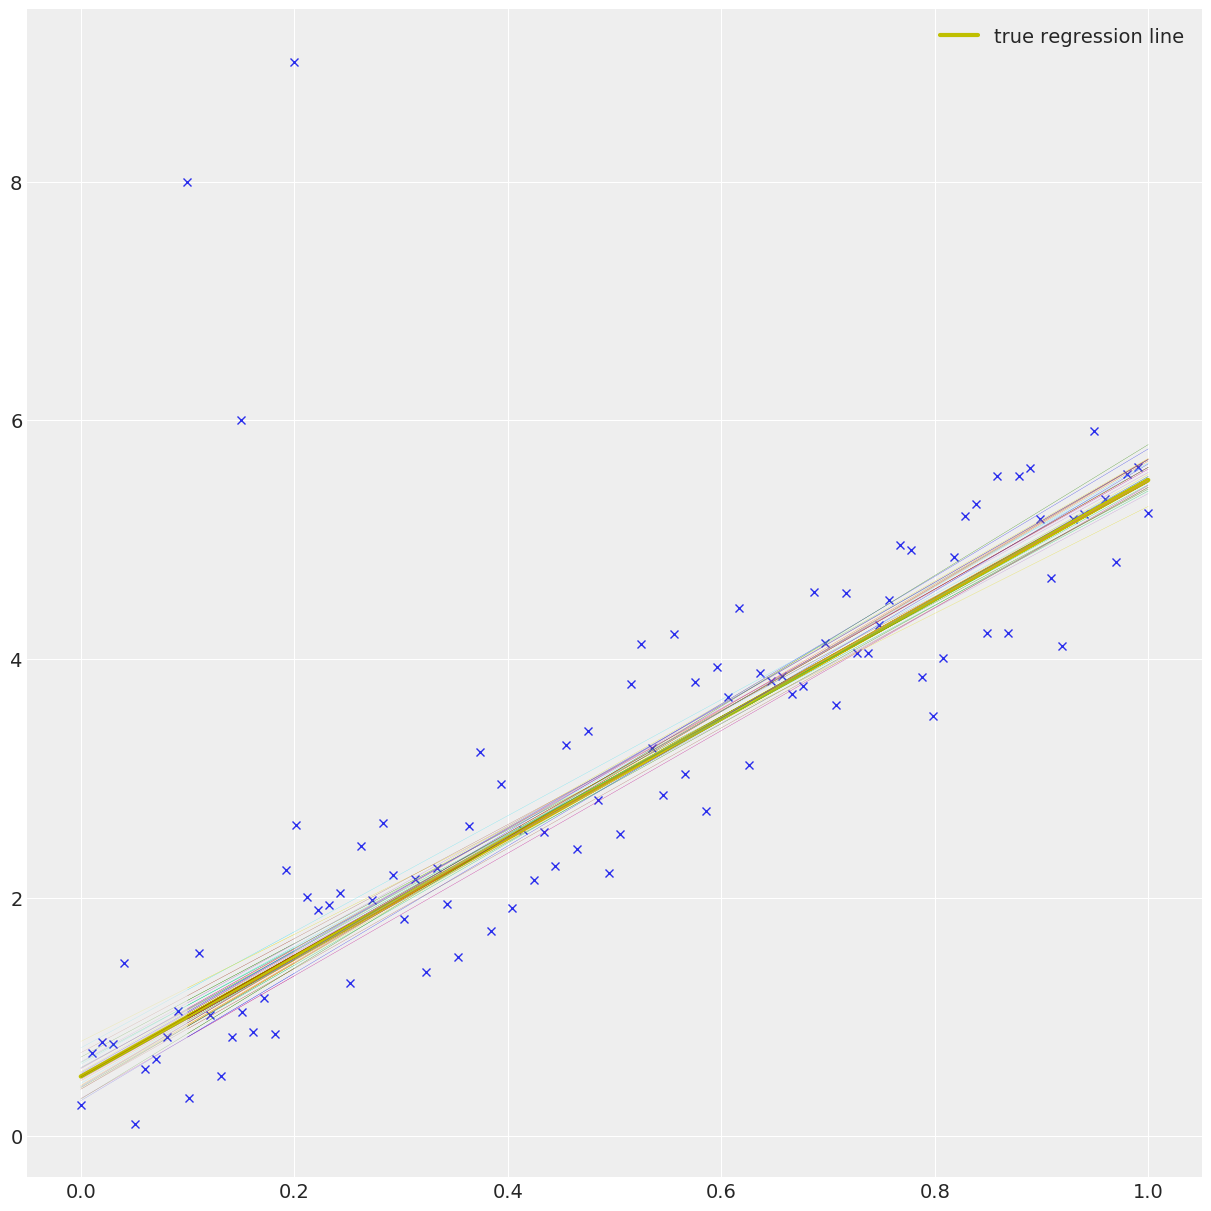

In [63]:
plt.figure(figsize=(12, 12))
plt.plot(data2["x"], data2["y"], 'x')
plt.plot(data2["x"], data2["mu"],
         label='true regression line', lw=3., c='y')

for l in listindex:
    plt.plot(data2["x"],my_output.loc[l,"Intercept"]+my_output.loc[l,"slope"]*data2["x"],lw=0.1)
    
plt.legend();


# Bayesian Regression In Real Data

In [28]:
google.shape

(1446, 7)

In [29]:
google["Y"]=google["Close"].shift(-1)-google["Close"] # the price chance in 3 days

In [30]:
# Next we build some predictors 
google["X1"]=(google["Close"]-google["Close"].shift(3))/3
google["X2"]=(google["Close"]-google["Close"].shift(6))/6
google["X3"]=(google["Close"]-google["Close"].shift(9))/9
google["X4"]=(google["Close"]-google["Close"].shift(12))/12
google["X5"]=(google["Close"]-google["Close"].shift(15))/15
google.dropna(inplace=True)

In [31]:
google.head()

,Open,High,Low,Close,Adj Close,Volume,return,Y,X1,X2,X3,X4,X5
Date,,,,,,,,,,,,,
2015-01-26,537.055542,537.524231,528.219788,533.744629,533.744629,1543700,-0.008779,-16.534607,5.707662,5.554754,4.727024,2.834719,0.691435
2015-01-27,528.518921,529.246948,516.771179,517.210022,517.210022,1904000,-0.030978,-8.606384,-5.238932,1.753525,2.487617,1.325528,0.316467
2015-01-28,521.348633,521.558044,508.603638,508.603638,508.603638,1683800,-0.016640,0.658173,-9.955994,0.515254,1.011668,1.149345,0.534534
2015-01-29,509.600891,509.690643,499.827728,509.261810,509.261810,4186300,0.001294,23.794708,-8.160940,-1.226639,0.982856,1.505033,0.635588
2015-01-30,514.447571,538.391846,514.108521,533.056519,533.056519,5606300,0.046724,-6.023499,5.282166,0.021617,2.929738,3.186254,2.116856


In [32]:
google.shape

(1430, 13)

In [33]:
n = google.shape[0]
n_train =  (int)(0.8 * n)
train = google[0:n_train]
test = google[n_train+1:n]

In [34]:
with pm.Model() as stock_prediction: # model specification

    # Define priors
    std = pm.HalfCauchy('sigma', beta=20, testval=1) # unique name for each variable
    intercept = pm.Normal('intercept', 0, sd=10)
    b1 = pm.Normal('b1', 0, sd=10)
    b2 = pm.Normal('b2', 0, sd=10)
    b3 = pm.Normal('b3', 0, sd=10)
    b4 = pm.Normal('b4', 0, sd=10)
    b5 = pm.Normal('b5', 0, sd=10)
    df = pm.Exponential('df', 1 / 29,testval=5) + 2.# make the df is around 2
    # Define likelihood
    likelihood =  pm.StudentT('y',nu=df, mu=intercept 
                           + b1 * train["X1"]
                           +b2*train["X2"]
                           +b3*train["X3"]
                           +b4*train["X4"]
                           +b5*train["X5"], 
                           sd=std, 
                           observed=train["Y"])

In [41]:
with stock_prediction:
    # Inference
    tune = 2000
    draws = 2000
    trace = pm.sample( tune=tune,
                       draws=draws, 
                       cores=4) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [df, b5, b4, b3, b2, b1, intercept, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 92 seconds.


/Users/kenneth/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13cd6e7f0>,
      dtype=object)

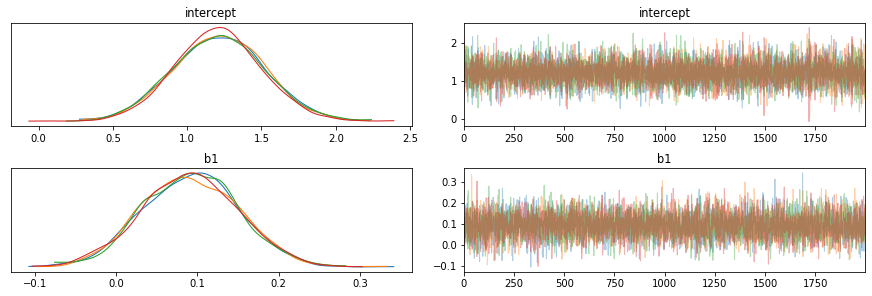

In [42]:
az.plot_trace(trace,var_names=("intercept","b1"))


In [43]:
trace_df = pm.trace_to_dataframe(trace).assign(chain=lambda x: x.index // draws)
trace_df.shape 

(8000, 9)

In [44]:
trace_df.head()

,intercept,b1,b2,b3,b4,b5,sigma,df,chain
0,0.474411,0.158385,-0.289336,0.220426,-0.644852,0.127532,9.099647,1.228108,0
1,0.530339,0.147792,-0.228153,0.255927,-0.468799,0.024782,8.849960,1.157372,0
2,1.624239,0.019882,-0.035750,0.119056,-0.796117,0.436116,8.278345,1.028674,0
3,1.353486,0.093426,-0.068033,0.153352,-0.675423,0.166378,8.713457,0.858094,0
4,1.886662,0.062652,-0.235952,0.016597,-0.355979,-0.037765,8.231791,1.097953,0


In [45]:
train.head()

,Open,High,Low,Close,Adj Close,Volume,return,Y,X1,X2,X3,X4,X5
Date,,,,,,,,,,,,,
2015-01-26,537.055542,537.524231,528.219788,533.744629,533.744629,1543700,-0.008779,-16.534607,5.707662,5.554754,4.727024,2.834719,0.691435
2015-01-27,528.518921,529.246948,516.771179,517.210022,517.210022,1904000,-0.030978,-8.606384,-5.238932,1.753525,2.487617,1.325528,0.316467
2015-01-28,521.348633,521.558044,508.603638,508.603638,508.603638,1683800,-0.016640,0.658173,-9.955994,0.515254,1.011668,1.149345,0.534534
2015-01-29,509.600891,509.690643,499.827728,509.261810,509.261810,4186300,0.001294,23.794708,-8.160940,-1.226639,0.982856,1.505033,0.635588
2015-01-30,514.447571,538.391846,514.108521,533.056519,533.056519,5606300,0.046724,-6.023499,5.282166,0.021617,2.929738,3.186254,2.116856


#### in-sample 

In [46]:
traceindex=pd.Series(trace_df.index)
train["predictedPrice"]=0
train["predictedDifference"]=0
for day in train.index:
    listindex=traceindex.sample(100).values
    total=[]
    for m in listindex:
        total.append(trace_df.loc[m,"intercept"]
             +trace_df.loc[m,"b1"]*train.loc[day,"X1"]
             +trace_df.loc[m,"b2"]*train.loc[day,"X2"]
             +trace_df.loc[m,"b3"]*train.loc[day,"X3"]
             +trace_df.loc[m,"b4"]*train.loc[day,"X4"]
             +trace_df.loc[m,"b5"]*train.loc[day,"X5"]
                    )
    train.loc[day,"predictedDifference"]=np.array(total).mean()
    train.loc[day,"predictedPrice"]= train.loc[day,"Close"] +train.loc[day,"predictedDifference"]
                     
        
    

/Users/kenneth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kenneth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kenneth/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [47]:
train["predictedDifference"].head()

Date
2015-01-26    0.265991
2015-01-27    0.126875
2015-01-28   -0.199142
2015-01-29    0.105434
2015-01-30    0.701674
Name: predictedDifference, dtype: float64

Text(0, 0.5, 'Stock Price')

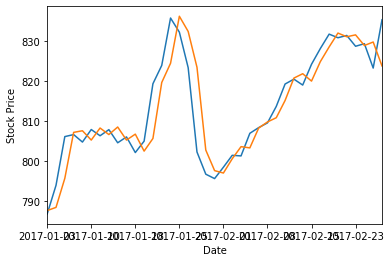

In [94]:
(train.loc["2017-01-01":"2017-02-29","Close"] + train.loc["2017-01-01":"2017-02-29","Y"]).plot()
(train.loc["2017-01-01":"2017-02-29","Close"] + train.loc["2017-01-01":"2017-02-29","predictedDifference"]).plot()
plt.ylabel("Stock Price")


Text(0.5, 0, 'real price difference')

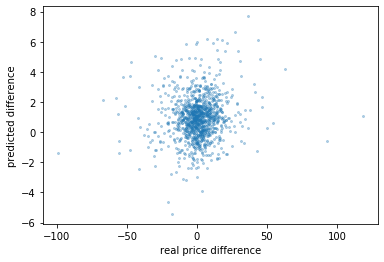

In [69]:

plt.scatter(train["Y"],train["predictedDifference"], alpha=0.3, s=4)
plt.ylabel("predicted difference")
plt.xlabel("real price difference")


In [70]:
from sklearn.metrics import r2_score
r2_score(train["Y"],train["predictedDifference"])

0.01226818626555426

#### out-sample 

In [71]:
traceindex=pd.Series(trace_df.index)
test["predictedPrice"]=0
test["predictedDifference"]=0
for day in test.index:
    listindex=traceindex.sample(100).values
    total=[]
    for m in listindex:
        total.append(trace_df.loc[m,"intercept"]
             +trace_df.loc[m,"b1"]*test.loc[day,"X1"]
             +trace_df.loc[m,"b2"]*test.loc[day,"X2"]
             +trace_df.loc[m,"b3"]*test.loc[day,"X3"]
             +trace_df.loc[m,"b4"]*test.loc[day,"X4"]
             +trace_df.loc[m,"b5"]*test.loc[day,"X5"]
                    )
    test.loc[day,"predictedDifference"]=np.array(total).mean()
    test.loc[day,"predictedPrice"]= test.loc[day,"Close"] +test.loc[day,"predictedDifference"]
                     
        
    

/Users/kenneth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kenneth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kenneth/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [72]:
test["predictedDifference"].head()

Date
2019-08-13    0.589717
2019-08-14    1.882693
2019-08-15    2.203070
2019-08-16    2.622890
2019-08-19    2.647646
Name: predictedDifference, dtype: float64

In [76]:
test["Y"].head()

Date
2019-08-13   -32.979980
2019-08-14     2.969971
2019-08-15    10.339966
2019-08-16    20.849976
2019-08-19   -15.760010
Name: Y, dtype: float64

Text(0, 0.5, 'Stock Price')

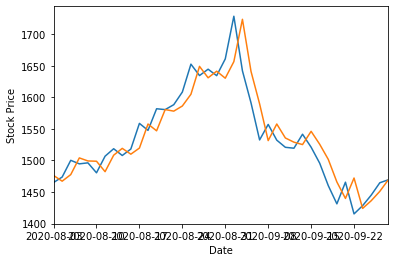

In [98]:
(test.loc["2020-08-01":"2020-09-29","Close"] + test.loc["2020-08-01":"2020-09-29","Y"]).plot()
(test.loc["2020-08-01":"2020-09-29","Close"] + test.loc["2020-08-01":"2020-09-29","predictedDifference"]).plot()
plt.ylabel("Stock Price")


Text(0.5, 0, 'real price difference')

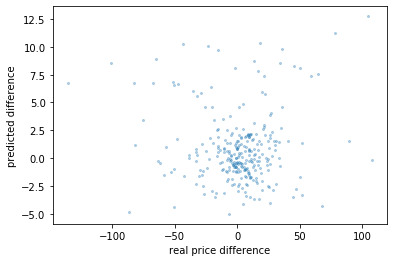

In [99]:

plt.scatter(test["Y"],test["predictedDifference"], alpha=0.3, s=4)
plt.ylabel("predicted difference")
plt.xlabel("real price difference")


In [100]:
from sklearn.metrics import r2_score
r2_score(test["Y"],test["predictedDifference"])

-0.015157710284178894